In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import itertools
import pickle
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, brier_score_loss 


In [38]:
alpha = 0.5
gamma = 1
seq_len = 1
learning_rate = 1e-4

batch_size = 32
max_epoch = 100
experiment_time = 1

#batch_size = 3200
#max_epoch = 2
#experiment_time = 5

limit_early_stop_count = 5


select_feature_flag = True
calculate_shap = True


use_upsample = False
use_mini_feature = False

if select_feature_flag:
    calculate_shap = True
    use_mini_feature = False
    
only_Weaning = False

task_name_list = ['Weaning_successful','SBT_start','SBT_successful']
#task_name_list = ['Weaning_successful','Mortality_30d','Vasopressor']
#task_name_list = ['Weaning_successful']

#data_date = "20231216"
#data_date = "20231224"
#data_date = "20231226"
#data_date = "20231227"
#data_date = "20240104"
data_date = "20240114"
device = torch.device("cuda")

In [39]:
print(device)

cuda


In [40]:
class MLP_MTL(nn.Module):
    def __init__(self, input_dim, task_name_list, dropout_ratio=0.0):
        super(MLP_MTL, self).__init__()

        self.dropout = nn.Dropout(dropout_ratio)
        self.relu = nn.ReLU()  # Activation function for hidden layers
        self.sigmoid = nn.Sigmoid()
        self.task_name_list = task_name_list
        self.num_tasks = len(task_name_list)
        hidden_dim = [256, 128, 64, 32]
        output_size = 1

        # Bottom
        self.bt_fc1 = nn.Linear(input_dim, hidden_dim[0])
        self.bt_fc2 = nn.Linear(hidden_dim[0], hidden_dim[1])
        self.bt_fc3 = nn.Linear(hidden_dim[1], hidden_dim[2])

        # Towers
        self.task_fc0 = nn.ModuleList([nn.Linear(hidden_dim[2], hidden_dim[3]) for _ in range(self.num_tasks)])
        self.task_fc1 = nn.ModuleList([nn.Linear(hidden_dim[3], output_size) for _ in range(self.num_tasks)])
    
    def data_check(self,x):
        if isinstance(x, np.ndarray):
            x = torch.tensor(x, dtype=torch.float32)
        if x.ndim == 3:
            x = x.reshape(x.shape[0], x.shape[1] * x.shape[2])  # Flatten 
            
        x = x.to(device)
        return x
    
    def forward(self, x):
        x = self.data_check(x)

        # Bottom
        x = self.bt_fc1(x)
        x = self.relu(x)
        x = self.bt_fc2(x)
        x = self.relu(x)
        x = self.bt_fc3(x)
        h = self.relu(x)
        h = self.dropout(h)  

        # Towers
        task_out = {}
        for task_index in range(self.num_tasks):
            task_name = self.task_name_list[task_index]
            hi = self.task_fc0[task_index](h)
            hi = self.relu(hi)
            hi = self.dropout(hi)
            hi = self.task_fc1[task_index](hi)
            hi = self.sigmoid(hi)
            task_out[task_name] = hi    
            
        if len(self.task_name_list) == 1:
            return task_out[self.task_name_list[0]]
        else:
            return task_out
    
    def predict_prob(self, x):
        self.eval()
        prob_dict = self.forward(x)
        
        if len(self.task_name_list) == 1:
            prob_dict_true = {}
            prob_dict_true[self.task_name_list[0]] = prob_dict
            return prob_dict_true
        return prob_dict

    def predict_proba(self, x):
        self.eval()
        prob_dict = self.forward(x)
        
        if len(self.task_name_list) == 1:
            prob_dict_true = {}
            prob_dict_true[self.task_name_list[0]] = prob_dict
            return prob_dict_true
        
        return prob_dict
    
    def predict(self, x, threshold = 0.5):
        self.eval()
        prob_dict = self.predict_prob(x)
        pred_dict = {}
        
        for key, value in prob_dict.items():
            #tensor轉numpy
            value = value.cpu().detach().numpy()
            pred_class = [1 if x > threshold else 0 for x in value]
            pred_dict[key] = np.array(pred_class) 
        return pred_dict
    
    def evaluate(self,X,label,task_name,criterion):
        with torch.no_grad():
            prob = self.predict_prob(X)[task_name].cpu().detach().numpy() #tensor=>numpy
            pred = self.predict(X)[task_name] 
            score = compute_scores(label,pred,prob)
            score['task'] = task_name
            loss = criterion(torch.from_numpy(prob).to(device),torch.from_numpy(label).to(device)).item()
            score['loss'] = loss/len(label)
            return score
        

    

In [41]:
def compute_scores(y_true, y_pred,y_prob):
    if np.any(np.isnan(y_prob)):
        print(y_prob)
        input()
        
    scores = {}
    try:
        scores['task'] = 'Null'
        scores['auroc'] = round(roc_auc_score(y_true, y_prob), 3)
        scores['acc'] = round(accuracy_score(y_true, y_pred), 3)
        scores['f1'] = round(f1_score(y_true, y_pred), 3)
        scores['pre'] = round(precision_score(y_true, y_pred), 3)
        scores['recall'] = round(recall_score(y_true, y_pred), 3)
        scores['brier_score'] = round(brier_score_loss(y_true, y_prob), 3)
    except Exception as e:
        print("An error occurred:", str(e))
    return scores

In [42]:
def train(model, loader_dict, criterion, optimizer):
    model.train()

    train_loss = 0
    task_name_list = list(loader_dict.keys())

    """
    cycle_loader
    """
    max_length = 0
    cycle_loader_dict = {}
    for task_name, dataloader in loader_dict.items():
        current_length = len(dataloader)
        max_length = max(max_length, current_length)
        cycle_loader_dict[task_name] = itertools.cycle(dataloader)

    for i in range(max_length):
        optimizer.zero_grad()
        
        total_loss = torch.zeros(1).to(device)
        for task_name in task_name_list:  
            data = next(cycle_loader_dict[task_name])
            x = data[0].to(device)
            label = data[1].unsqueeze(1).to(device)
            prob = model.predict_prob(x)[task_name]
            loss = criterion(prob, label)
            total_loss += loss
            if task_name == 'Weaning_successful':
                total_loss += loss
            
        total_loss.backward()
        train_loss+=total_loss.item()
        optimizer.step()
        
        for task_name in task_name_list: 
            if (i + 1) % len(loader_dict[task_name]) == 0:
                cycle_loader_dict[task_name] = itertools.cycle(loader_dict[task_name])
                
    train_loss /= max_length* 256 * len(task_name_list)
    
    return train_loss

In [43]:
"""
Input:
    model
    dict: Mydataset
    loss_function
Output:
    score: dict + dict
    result: dict => ['total_auc','total_loss']
"""
def test(model, dataset_dict, criterion, is_show = True , only_Weaning = False):
    model.eval()

    task_name_list = list(dataset_dict.keys())
    score = {}
    result = {'total_auc': 0, 'total_loss': 0}
    for task_name in task_name_list:  # 循環每個任務
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
    
        score[task_name] = model.evaluate(X,Y,task_name,criterion)
        
        if only_Weaning == True and 'Weaning_succecssful' in task_name_list:
            if task_name == 'Weaning_succecssful':
                result['total_auc'] = result['total_auc'] + score[task_name]['auroc']
                result['total_loss'] = result['total_loss'] + score[task_name]['loss']
        else:
            result['total_auc'] = result['total_auc'] + score[task_name]['auroc']
            result['total_loss'] = result['total_loss'] + score[task_name]['loss']
            
        if is_show:
            print(score[task_name])
    
    return score,result

"""
local_best_model_dict: #dict{'task_name':{'model','performance(target_score)','id'}}
model
"""
def test2(local_best_model_dict, modelr, dataset_dict, criterion, is_show = True):
    score = {}
    result = {'total_auc': 0, 'total_loss': 0}
    task_name_list = list(dataset_dict.keys())
    
    for task_name in task_name_list:
        print(f"task: {task_name} ")
        print(f"{local_best_model_dict[task_name]['performance']}")
        modelr.load_state_dict(local_best_model_dict[task_name]['model'])
        modelr.eval()
        X = dataset_dict[task_name].inputs.numpy()
        Y = dataset_dict[task_name].labels.unsqueeze(1).numpy()
        score[task_name] = modelr.evaluate(X,Y,task_name,criterion)
        result['total_auc'] = result['total_auc'] + score[task_name]['auroc']
        result['total_loss'] = result['total_loss'] + score[task_name]['loss']
        if is_show:
            print(score[task_name])
            
    return score,result

In [44]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class MyDataset(Dataset):
    def __init__(self, np_X_scalar,np_X_original, np_Y):
        self.inputs = torch.from_numpy(np_X_scalar).float()
        self.inputs_original = torch.from_numpy(np_X_original).float()
        self.labels = torch.from_numpy(np_Y).float()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]
    
    def remove_samples(self, feature_index, threshold, condition_type):
        """
        Remove samples based on a specified condition on a specific feature.

        Parameters:
        - feature_index (int): Index of the feature.
        - threshold (float): Threshold value for the condition.
        - condition_type (str): Type of condition ('type1' for '<' or 'type2' for '>=').
        """
        if condition_type == 'type1':
            indices_to_remove = torch.nonzero(self.inputs[:, feature_index] < threshold).squeeze()
        elif condition_type == 'type2':
            indices_to_remove = torch.nonzero(self.inputs[:, feature_index] >= threshold).squeeze()
        else:
            raise ValueError("Invalid condition_type. Use 'type1' for '<' or 'type2' for '>='.")

        # Remove samples
        self.inputs = torch.index_select(self.inputs, 0, indices_to_remove)
        self.inputs_original = torch.index_select(self.inputs_original, 0, indices_to_remove)
        self.labels = torch.index_select(self.labels, 0, indices_to_remove)
    
class BCEFocalLoss(torch.nn.Module):

    def __init__(self, gamma=2, alpha=0.25, reduction='elementwise_mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
 
    def forward(self, _input, target):
        pt = _input
        alpha = self.alpha
        loss = - alpha * (1 - pt) ** self.gamma * target * torch.log(pt) - \
               (1 - alpha) * pt ** self.gamma * (1 - target) * torch.log(1 - pt)
        if self.reduction == 'elementwise_mean':
            loss = torch.mean(loss)
        elif self.reduction == 'sum':
            loss = torch.sum(loss)
        return loss    

    
def check_label_distribution (data_Y):
    count_1 = np.count_nonzero(data_Y == 1)
    count_0 = np.count_nonzero(data_Y == 0)
    count_others = np.count_nonzero((data_Y != 1) & (data_Y != 0))
    ratio_1 = round(count_1/len(data_Y)*100,2)
    ratio_0 = round(count_0/len(data_Y)*100,2)
    ratio_others = round(count_others/len(data_Y)*100,2)
    print(f'Distribution: 1=>{count_1}({ratio_1}%),  0=>{count_0}({ratio_0}%),  others=>{count_others}({ratio_others}%)')

    
def upsampling_auto(X,X_original,Y,up_ratio):
    check_label_distribution(Y)
    zero_idx = np.where(Y == 0)[0]
    one_idx = np.where(Y == 1)[0]
    other_idx = np.where((Y != 1) & (Y != 0))[0]
    if len(other_idx > 0):
        return X,Y
    repeated_data_X = np.tile(X[one_idx], (up_ratio, 1, 1))
    repeated_data_X_original = np.tile(X_original[one_idx], (up_ratio, 1, 1))
    repeated_data_Y = np.tile(Y[one_idx], (up_ratio))

    X_upsampled = np.vstack((X[zero_idx], repeated_data_X))
    X_original_upsampled = np.vstack((X_original[zero_idx], repeated_data_X_original))

    Y_upsampled = np.concatenate((Y[zero_idx], repeated_data_Y)) 
    return X_upsampled,X_original_upsampled, Y_upsampled

In [45]:
import numpy as np

"""
Input:
    X: numpy
    feature_name_list : List
    select_feature_list : List   (必須是feature_name_list的子集)
Output
    select_feature_list data
"""
def select_features(X, feature_name_list, select_feature_list):
    invalid_features = set(select_feature_list) - set(feature_name_list)
    if invalid_features:
        raise ValueError(f"Invalid features in select_feature_list: {invalid_features}")
    selected_feature_indices = [feature_name_list.index(feature) for feature in select_feature_list]
    X_selected = X[:, :, selected_feature_indices]

    return X_selected

In [46]:
"""
Input:
    dataset_dict: Mydataset 
    loader_dict: Dataloader
    feature_name_list: List
    select_feature_list: List 
    batch_size: 256

Output:
    dataset_dict
    loader_dict
    feature_name_list ==>
"""

def read_data(task_name_list, data_date ,data_type, select_feature_list = [], batch_size = 256,use_upsample = False):
    data_path = "data/sample/standard_data"
    
    #Feature name
    df_feature = pd.read_csv("data/sample/full_feature_name.csv")
    feature_name_list = df_feature.columns.to_list()
    
    #Dataset
    dataset_dict = {}
    for task_name in task_name_list:
        X_scalar = np.load(f"{data_path}/{data_type}_scalar_X_{task_name}.npy", allow_pickle=True)
        X_original = np.load(f"{data_path}/{data_type}_X_{task_name}.npy", allow_pickle=True)
        
        if len(select_feature_list)>0:
            X_scalar = select_features(X_scalar,feature_name_list,select_feature_list)
            X_original = select_features(X_original,feature_name_list,select_feature_list)
            assert X_scalar.shape[2] == len(select_feature_list)
            assert X_original.shape[2] == len(select_feature_list)
            
        Y = np.load(f"{data_path}\\{data_type}_Y_{task_name}.npy", allow_pickle=True)
        
        if use_upsample:
            if task_name == 'Weaning_successful' and data_type != 'test':
                X_scalar,X_original,Y = upsampling_auto(X_scalar,X_original,Y,2)
        dataset_dict[task_name] = MyDataset(X_scalar,X_original,Y)
    
    #Dataloader
    loader_dict = {}
    for key, dataset in dataset_dict.items():        
        loader_dict[key] = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataset_dict,loader_dict,feature_name_list



In [47]:
def MTL_to_STL(multi_task_model):
    single_task_models = {}

    for task_index, task_name in enumerate(multi_task_model.task_name_list):
        
        single_task_model = MLP_MTL(input_dim, [task_name])  
        single_task_model.to(device) 

        single_task_model.bt_fc1.weight.data = multi_task_model.bt_fc1.weight.data.clone()
        single_task_model.bt_fc1.bias.data = multi_task_model.bt_fc1.bias.data.clone()

        single_task_model.bt_fc2.weight.data = multi_task_model.bt_fc2.weight.data.clone()
        single_task_model.bt_fc2.bias.data = multi_task_model.bt_fc2.bias.data.clone()

        single_task_model.bt_fc3.weight.data = multi_task_model.bt_fc3.weight.data.clone()
        single_task_model.bt_fc3.bias.data = multi_task_model.bt_fc3.bias.data.clone()

        single_task_model.task_fc0[0].weight.data = multi_task_model.task_fc0[task_index].weight.data.clone()
        single_task_model.task_fc0[0].bias.data = multi_task_model.task_fc0[task_index].bias.data.clone()

        single_task_model.task_fc1[0].weight.data = multi_task_model.task_fc1[task_index].weight.data.clone()
        single_task_model.task_fc1[0].bias.data = multi_task_model.task_fc1[task_index].bias.data.clone()

        single_task_models[task_name] = single_task_model
    return single_task_models

In [48]:
def save_model(task_name_list, model_parm_dict, mode, time_id):

    path = ''
    if len(task_name_list) == 1:
        path = "./model/group_result/stl_group"
    elif 'SBT_start' in task_name_list:
        path = "./model/group_result/mtl_group/vent_group"
    else:
        path = "./model/group_result/mtl_group/mortality_group"
    
    for task_name in task_name_list:
        model_parm = model_parm_dict[task_name].state_dict().copy()

        if mode == 'lite':
            torch.save(model_parm, f'{path}/{task_name}_{time_id}_lite')
        else:
            torch.save(model_parm, f'{path}/{task_name}_{time_id}')

def save_feature_name(feature_name_list,path,file_name):
    df_feature = pd.DataFrame()
    df_feature['Feature'] = feature_name_list
    df_feature.to_csv(f'{path}/{file_name}.csv',index = False)
    

In [49]:
"""
Input:
    experiment_time
    max_epoch
    learning_rate
    input_dim
    task_name_list
    train_loader_dict
    val_dataset_dict
    test_dataset_dict
    device
    is_show

Output:
    df_grade
    stl_model_dict
"""


def train_and_test_model(experiment_time, max_epoch, learning_rate, input_dim, task_name_list, train_loader_dict, val_dataset_dict, test_dataset_dict, device,is_show = True , load_parm = {}):
    df_grade = pd.DataFrame(columns=['time', 'task', 'auroc', 'acc', 'f1', 'pre', 'recall', 'brier_score', 'loss'])
    best_model_params = {}
    global_best_AUC = 0
    global_best_loss = 10000
    best_model_dict = {} 
    
    count = 1
    local_indicator = 'auroc'
    global_indicator = 'loss'
    
    if len(load_parm)!=0:
        assert len(task_name_list) == 1 or 'Weaning_successful' not in task_name_list, f'The number of tasks is not 1 => {task_name_list}'
        
        load_model = MLP_MTL(input_dim, task_name_list).to(device)
        load_model.load_state_dict(load_parm)
        load_model.eval()
        
        loss_func = BCEFocalLoss(alpha=alpha, gamma=gamma)
        
        result = test(load_model, test_dataset_dict, loss_func, is_show = True)
        return load_model,result
    
    for time in range(experiment_time):
        train_loss_list = []
        val_loss_list = []
        auc_list = []    
        local_best_AUC = 0
        local_best_loss = 10000
        local_best_model_dict = {} 
        patience_counter = 0
        
        model = MLP_MTL(input_dim, task_name_list).to(device)
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.001)
        loss_func = BCEFocalLoss(alpha=alpha, gamma=gamma)
        
        for epoch in tqdm(range(max_epoch)):
            if is_show:
                print(f'Time:{time+1}/{experiment_time} - Epoch:{epoch+1}/{max_epoch}...')
                
            train_loss = train(model, train_loader_dict, loss_func, optimizer)
            val_score_dict, result = test(model, val_dataset_dict, loss_func, is_show= is_show, only_Weaning = only_Weaning)
            
            train_loss_list.append(train_loss)
            val_loss_list.append(result['total_loss'])
            auc_list.append(result['total_auc'])
            
            ########################################################################################################################
            for task_name in task_name_list:
                if task_name not in local_best_model_dict:
                    model_dict = {}
                    model_dict['model'] = model.state_dict().copy()
                    model_dict['performance'] = val_score_dict[task_name]
                    model_dict['id'] = count
                    local_best_model_dict[task_name] = model_dict
                else:
                    target_score = val_score_dict[task_name]
                    if local_indicator == 'auroc':
                        if local_best_model_dict[task_name]['performance'][local_indicator] < target_score[local_indicator] :
                            local_best_model_dict[task_name]['performance'] = target_score
                            local_best_model_dict[task_name]['model'] = model.state_dict().copy()
                            local_best_model_dict[task_name]['id'] = count                           
                    else:
                        if local_best_model_dict[task_name]['performance'][local_indicator] > target_score[local_indicator] :
                            local_best_model_dict[task_name]['performance'] = target_score
                            local_best_model_dict[task_name]['model'] = model.state_dict().copy()
                            local_best_model_dict[task_name]['id'] = count
                    
            for task_name in task_name_list:
                if task_name not in best_model_dict:
                    model_dict = {}
                    model_dict['model'] = model.state_dict().copy()
                    model_dict['performance'] = val_score_dict[task_name]
                    model_dict['id'] = count
                    best_model_dict[task_name] = model_dict
                else:
                    target_score = val_score_dict[task_name]
                    if local_indicator == 'auroc':
                        if best_model_dict[task_name]['performance'][local_indicator] < target_score[local_indicator] :
                            best_model_dict[task_name]['performance'] = target_score
                            best_model_dict[task_name]['model'] = model.state_dict().copy()
                            best_model_dict[task_name]['id'] = count
                    else:
                        if best_model_dict[task_name]['performance'][local_indicator] > target_score[local_indicator] :
                            best_model_dict[task_name]['performance'] = target_score
                            best_model_dict[task_name]['model'] = model.state_dict().copy()
                            best_model_dict[task_name]['id'] = count
            count+=1

            ########################################################################################################################
            """ Early stop """
            if global_indicator == 'loss':
                if result['total_loss'] < local_best_loss:
                    local_best_loss = result['total_loss']
                    if local_best_loss < global_best_loss:
                        global_best_loss = local_best_loss
                        best_model_params = model.state_dict().copy() 
                    patience_counter = 0
                else:
                    patience_counter += 1     
            else:
                if result['total_auc'] > local_best_AUC:
                    local_best_AUC = result['total_auc']
                    if local_best_AUC > global_best_AUC:
                        global_best_AUC = local_best_AUC
                        best_model_params = model.state_dict().copy()
                    patience_counter = 0
                else:
                    patience_counter += 1 
            
            global limit_early_stop_count
            if patience_counter >= limit_early_stop_count:
                break
        
        #is_show = True
        empty_model = MLP_MTL(input_dim, task_name_list).to(device)
        test_score_dict, result = test2(local_best_model_dict, empty_model, test_dataset_dict, loss_func, is_show = is_show)
        ########################################################################################################################
        #input()
        for task_name in task_name_list:
            test_score_dict[task_name]['time'] = time + 1
            df_grade = pd.concat([df_grade, pd.DataFrame.from_records([test_score_dict[task_name]])])
        print(df_grade)
        print('----------finished----------')
    
    
    global_stl_model_dict = {}
    for task_name in task_name_list:
        model = MLP_MTL(input_dim, task_name_list).to(device)
        model.load_state_dict(best_model_dict[task_name]['model'])
        local_stl_model_dict = MTL_to_STL(model)
        global_stl_model_dict[task_name] = local_stl_model_dict[task_name]
    
    return df_grade, global_stl_model_dict, best_model_dict
    
    

In [50]:
import shap
import matplotlib.pyplot as plt
"""
Input:
    shap_value: flatten的結果,[sample,feature]
    feature_name_list: flatten的feature list
Output:
    feature_important 
    sum_per_feature 
"""
def calculate_feature_important(shap_value,feature_name_list):
    abs_shap_value = np.abs(shap_value)
    sum_per_feature = np.sum(abs_shap_value, axis=0)
    sorted_feature_indices = np.argsort(sum_per_feature)[::-1] #[::-1]是reversed
    sorted_feature_names = [feature_name_list[i] for i in sorted_feature_indices]
    return sorted_feature_names, sum_per_feature

"""
Input:
    model  
    train_X (np)
    test_X  (np)
    test_X_original (np)
    feature_name_list (list)
    task_name (string)
Output:
    shap_value
    shap_data
    (flatten的結果)
"""
def get_model_shap(model,data_X_train,data_X_test,data_X_test_original,feature_name_list,task_name,use_mini_sample = True,n_sample = 100):
    
    max_sample = 1000
    seq_day = data_X_train.shape[1]
    feature_count = data_X_train.shape[2]
    
    if use_mini_sample:
        background_data = torch.from_numpy(data_X_train[:max_sample]).float().to(device)
        shap_data = torch.from_numpy(data_X_test[:max_sample]).float().to(device)
        shap_data_original = torch.from_numpy(data_X_test_original[:max_sample]).float().to(device)
    else:
        background_data = torch.from_numpy(data_X_train[:]).float().to(device)
        shap_data = torch.from_numpy(data_X_test[:]).float().to(device)
        shap_data_original = torch.from_numpy(data_X_test_original[:]).float().to(device)

    model.eval()
    explainer = shap.GradientExplainer(model, background_data)
    
    shap_values = explainer.shap_values(shap_data,nsamples=n_sample)
    shap_values = np.array(shap_values)
    
    shap_value_flatten = np.zeros((len(shap_data),seq_day*feature_count))
    shap_data_flatten = np.zeros((len(shap_data),seq_day*feature_count))
    
    for i in range(0,len(shap_data)):
        count=0
        for j in range(feature_count):
            for k in range(seq_day):
                shap_value_flatten[i][count]=shap_values[i][k][j]  
                shap_data_flatten[i][count]=shap_data_original[i][k][j]  
                count += 1
    feature_important,_ = calculate_feature_important(shap_value_flatten, feature_name_list)
    return feature_important, shap_value_flatten, shap_data_flatten

"""
Input:
    shap_value_flatten (sample,feature_flatten)
    shap_data_flatten (sample,feature_flatten)
    max_display 
"""
def show_shap(shap_value_flatten, shap_data_flatten,feature_name_list, max_display = 20,task_name = ''):
    fig = shap.summary_plot(shap_value_flatten,shap_data_flatten,feature_names=feature_name_list, show=False,max_display = max_display)
    plt.title(f"***Task:{task_name}***")
    ax = plt.gca()  
    plt.show()

# Start

In [52]:
select_feature_list = []

if use_mini_feature:
    df_select_feature = pd.read_csv('./data/sample/select_feature.csv')
    print(df_select_feature)
    select_feature_list = df_select_feature['feature'].tolist()

==> input_dim: 101
training


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  1%|▊                                                                                 | 1/100 [00:01<02:25,  1.47s/it]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to

task: Weaning_successful 
{'task': 'Weaning_successful', 'auroc': 0.78, 'acc': 0.728, 'f1': 0.395, 'pre': 0.582, 'recall': 0.299, 'brier_score': 0.177, 'loss': 0.0003531794167227215}
task: SBT_start 
{'task': 'SBT_start', 'auroc': 0.792, 'acc': 0.73, 'f1': 0.618, 'pre': 0.681, 'recall': 0.566, 'brier_score': 0.183, 'loss': 0.00026047491345414984}
task: SBT_successful 
{'task': 'SBT_successful', 'auroc': 0.782, 'acc': 0.734, 'f1': 0.557, 'pre': 0.697, 'recall': 0.464, 'brier_score': 0.182, 'loss': 0.0002686673366807596}
  time                task  auroc    acc     f1    pre  recall  brier_score  \
0    1  Weaning_successful  0.823  0.778  0.649  0.597   0.712        0.168   
0    1           SBT_start  0.817  0.753  0.672  0.749   0.610        0.179   
0    1      SBT_successful  0.818  0.761  0.643  0.759   0.557        0.174   

       loss  
0  0.000332  
0  0.000259  
0  0.000258  
----------finished----------
input dim:101 ==> 50.....
==> input_dim: 50
training


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  1%|▊                                                                                 | 1/100 [00:01<02:19,  1.41s/it]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to

task: Weaning_successful 
{'task': 'Weaning_successful', 'auroc': 0.784, 'acc': 0.719, 'f1': 0.526, 'pre': 0.528, 'recall': 0.523, 'brier_score': 0.174, 'loss': 0.00035349068542321523}
task: SBT_start 
{'task': 'SBT_start', 'auroc': 0.805, 'acc': 0.724, 'f1': 0.6, 'pre': 0.682, 'recall': 0.536, 'brier_score': 0.178, 'loss': 0.00025432490738185905}
task: SBT_successful 
{'task': 'SBT_successful', 'auroc': 0.804, 'acc': 0.732, 'f1': 0.578, 'pre': 0.669, 'recall': 0.508, 'brier_score': 0.175, 'loss': 0.0002576914471639714}
  time                task  auroc    acc     f1    pre  recall  brier_score  \
0    1  Weaning_successful  0.836  0.781  0.573  0.654   0.510        0.155   
0    1           SBT_start  0.816  0.736  0.608  0.788   0.495        0.178   
0    1      SBT_successful  0.822  0.733  0.555  0.776   0.432        0.174   

       loss  
0  0.000313  
0  0.000267  
0  0.000265  
----------finished----------
input dim:50 ==> 25.....
==> input_dim: 25
training


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  1%|▊                                                                                 | 1/100 [00:01<02:15,  1.37s/it]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to

task: Weaning_successful 
{'task': 'Weaning_successful', 'auroc': 0.781, 'acc': 0.703, 'f1': 0.0, 'pre': 0.0, 'recall': 0.0, 'brier_score': 0.201, 'loss': 0.00039021517667505476}
task: SBT_start 
{'task': 'SBT_start', 'auroc': 0.804, 'acc': 0.72, 'f1': 0.628, 'pre': 0.645, 'recall': 0.612, 'brier_score': 0.181, 'loss': 0.00025534476989354845}
task: SBT_successful 
{'task': 'SBT_successful', 'auroc': 0.805, 'acc': 0.736, 'f1': 0.611, 'pre': 0.652, 'recall': 0.575, 'brier_score': 0.177, 'loss': 0.00025744028614320505}
  time                task  auroc    acc     f1    pre  recall  brier_score  \
0    1  Weaning_successful  0.821  0.778  0.588  0.633   0.548        0.161   
0    1           SBT_start  0.811  0.751  0.656  0.769   0.571        0.180   
0    1      SBT_successful  0.819  0.763  0.649  0.757   0.568        0.174   

       loss  
0  0.000325  
0  0.000261  
0  0.000256  
----------finished----------
input dim:25 ==> 12.....
==> input_dim: 12
training


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  1%|▊                                                                                 | 1/100 [00:01<02:20,  1.42s/it]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to

task: Weaning_successful 
{'task': 'Weaning_successful', 'auroc': 0.778, 'acc': 0.753, 'f1': 0.548, 'pre': 0.6, 'recall': 0.505, 'brier_score': 0.175, 'loss': 0.0003520715981721878}
task: SBT_start 
{'task': 'SBT_start', 'auroc': 0.786, 'acc': 0.696, 'f1': 0.555, 'pre': 0.64, 'recall': 0.49, 'brier_score': 0.187, 'loss': 0.0002648349285595986}
task: SBT_successful 
{'task': 'SBT_successful', 'auroc': 0.774, 'acc': 0.704, 'f1': 0.533, 'pre': 0.618, 'recall': 0.469, 'brier_score': 0.187, 'loss': 0.00027180809370228943}
  time                task  auroc    acc     f1    pre  recall  brier_score  \
0    1  Weaning_successful  0.811  0.753  0.491  0.606   0.413        0.162   
0    1           SBT_start  0.819  0.718  0.576  0.764   0.462        0.186   
0    1      SBT_successful  0.811  0.723  0.558  0.725   0.453        0.184   

       loss  
0  0.000326  
0  0.000264  
0  0.000265  
----------finished----------
input dim:12 ==> 11.....
==> input_dim: 11
training


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  1%|▊                                                                                 | 1/100 [00:01<02:10,  1.32s/it]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to

task: Weaning_successful 
{'task': 'Weaning_successful', 'auroc': 0.769, 'acc': 0.747, 'f1': 0.556, 'pre': 0.582, 'recall': 0.533, 'brier_score': 0.179, 'loss': 0.0003565832558605406}
task: SBT_start 
{'task': 'SBT_start', 'auroc': 0.796, 'acc': 0.71, 'f1': 0.55, 'pre': 0.687, 'recall': 0.459, 'brier_score': 0.182, 'loss': 0.0002629880662970759}
task: SBT_successful 
{'task': 'SBT_successful', 'auroc': 0.783, 'acc': 0.714, 'f1': 0.527, 'pre': 0.653, 'recall': 0.441, 'brier_score': 0.182, 'loss': 0.00026912558486524}
  time                task  auroc    acc     f1    pre  recall  brier_score  \
0    1  Weaning_successful  0.812  0.767  0.576  0.606   0.548        0.169   
0    1           SBT_start  0.816  0.718  0.583  0.752   0.476        0.185   
0    1      SBT_successful  0.810  0.711  0.520  0.722   0.406        0.184   

       loss  
0  0.000331  
0  0.000263  
0  0.000271  
----------finished----------
input dim:11 ==> 10.....
==> input_dim: 10
training


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  1%|▊                                                                                 | 1/100 [00:01<02:19,  1.41s/it]Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to

KeyboardInterrupt: 

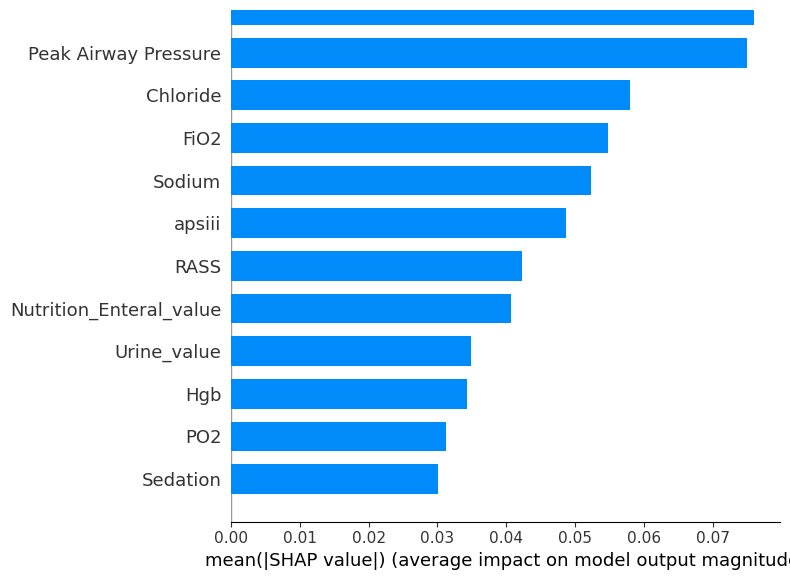

In [53]:
#select_feature_list = []
top_percent = 0.9
remove_time_count = 0
full_result_dict = {}
featurn_count_list = []


while len(select_feature_list)==0 or len(select_feature_list) > 5:
    ########################################################################################################################
    remove_time_count += 1
    """
    read data
    """
    train_dataset_dict,train_loader_dict,feature_name_list = read_data(task_name_list,'','train',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
    val_dataset_dict,val_loader_dict,_ = read_data(task_name_list,'','validation',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
    test_dataset_dict,test_loader_dict,_ = read_data(task_name_list,'','test',select_feature_list,batch_size = batch_size,use_upsample = use_upsample)
    if len(select_feature_list)!=0:
        feature_name_list = select_feature_list
    input_dim = train_dataset_dict[task_name_list[0]].inputs.numpy().shape[2]
    print(f'==> input_dim: {input_dim}')
    featurn_count_list.append(input_dim)
    ########################################################################################################################
    """
    Train
    """
    print("training")
    df_grade, stl_model_dict, best_model_dict = train_and_test_model(experiment_time = experiment_time, 
                                                     max_epoch = max_epoch, 
                                                     learning_rate = learning_rate, 
                                                     input_dim = input_dim, 
                                                     task_name_list = task_name_list, 
                                                     train_loader_dict = train_loader_dict, 
                                                     val_dataset_dict = val_dataset_dict, 
                                                     test_dataset_dict = test_dataset_dict, 
                                                     device = device, is_show = False)
    df_grade['remove_time'] = remove_time_count
    full_result_dict[remove_time_count] = {}
    full_result_dict[remove_time_count]['result'] = df_grade
    full_result_dict[remove_time_count]['model'] = stl_model_dict
    full_result_dict[remove_time_count]['select_feature_list'] = feature_name_list
    
    if calculate_shap == False:
        break
        
    ########################################################################################################################
    """
    Shap
    """
    shap_dict = {}
    seq_day = 1
    feature_count = len(feature_name_list)
    sum_shap_value = np.zeros((0, seq_day * feature_count))
    sum_shap_data = np.zeros((0, seq_day * feature_count))
    #計算各任務的feature_important
    for task_name in task_name_list:
        shap_dict[task_name] = {}
        feature_important, shap_value_flatten, shap_data_flatten = get_model_shap(
                                                                    stl_model_dict[task_name],
                                                                    train_dataset_dict[task_name].inputs.numpy(),
                                                                    test_dataset_dict[task_name].inputs.numpy(),
                                                                    test_dataset_dict[task_name].inputs_original.numpy(),
                                                                    feature_name_list,
                                                                    task_name,
                                                                    use_mini_sample = False,
                                                                    n_sample = 1)
        
        shap_dict[task_name]['feature_important'] = feature_important
        shap_dict[task_name]['shap_value'] = shap_value_flatten
        shap_dict[task_name]['shap_data'] = shap_data_flatten
        shap_dict[task_name]['feature_name_list'] = feature_name_list

        sum_shap_value = np.vstack([sum_shap_value, shap_value_flatten])
        sum_shap_data = np.vstack([sum_shap_data, shap_data_flatten]) 

    full_result_dict[remove_time_count]['shap_result'] = shap_dict
    
    ########################################################################################################################
    """
    select feature
    """
    global_feature_important, _ = calculate_feature_important(sum_shap_value, feature_name_list)
    full_result_dict[remove_time_count]['global_feature_important'] = global_feature_important
    
    if select_feature_flag == False:
        break
        
    shap.summary_plot(sum_shap_value,sum_shap_data,plot_type="bar",feature_names=feature_name_list, show=False,max_display = 20)
    
    if len(global_feature_important) <= 20:
        select_feature_list = global_feature_important[:len(global_feature_important)-1]
    else:
        num_selected_features = int(len(global_feature_important) * top_percent)
        num_selected_features = max(1, num_selected_features)
        select_feature_list = global_feature_important[:num_selected_features]
        
    print(f'input dim:{len(global_feature_important)} ==> {len(select_feature_list)}.....')

    ########################################################################################################################
    

In [58]:
""""""
max_length = 120

#跑特徵篩選
if select_feature_flag:
    df_select_features = pd.DataFrame()
    path = "./model/select_feature_result/"
    for time in range(1,remove_time_count+1):
        save_feature_name(full_result_dict[time]['select_feature_list'], path, f'feature_name_list_{time}')
        for task_name in task_name_list:
            model_parm = full_result_dict[time]['model'][task_name].state_dict()
            torch.save(model_parm, f'{path}/{task_name}_{time}')
#跑Overlap
else:
    if input(f'save?(y/n)') == 'y':
        path = "./overlap"
        if 'SBT_start' in task_name_list:
            group_name = 'vent'
        else:
            group_name = 'mortality'
        time = 1
        save_feature_name(full_result_dict[time]['select_feature_list'], path, 'feature_name_list')
        for task_name in task_name_list:
            torch.save(model_parm, f'{path}/{task_name}_group_{group_name}')

    